In [65]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import json
from tqdm import tqdm
import re
import time
import argparse

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image

/kaggle/input/crohme-data-basic/filtered_basic_arithmetic/train/images/expr_009203.png


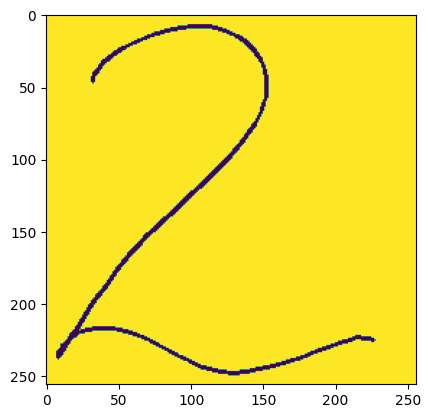

In [3]:
train_path = "/kaggle/input/crohme-data-basic/filtered_basic_arithmetic/train"
img_path = train_path+"/images/expr_"+"009203.png"
print(img_path)
img = Image.open(img_path)
plt.imshow(img)

In [4]:
train_path = "/kaggle/input/crohme-data/val"
#print(os.path.join(train_path,"labels"))
count = 0
for files in os.listdir(os.path.join(train_path,"labels"))[:10]:
    #print(files)
    label_path = train_path+"/labels/"+files
    count+=1
    #print(label_path)
    f = open(label_path, 'r')
    print(f.read())
print(count)

{ 1 \mbox { u } }
$77 + 113 \geq 189$
x_x^x + y_y^y + z_z^z - x - y - z
\log \Delta
\left [ { P } _ { \mbox { I } } \right ]
{ \sigma = 6 }
$j^2 = +1$
$5 / (37 + 36 + 8) = 0.06$
$\frac{a}{\sin A} = \frac{b}{\sin B} = \frac{c}{\sin C}$
3 0 \times 2 9 x^{2 8}
10


In [5]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

In [6]:
# Configuration
class Config:
    def __init__(self):
        # Dataset paths
        self.data_root = '/kaggle/input/crohme-data'
        
        # Model parameters
        self.embed_dim = 256
        self.hidden_dim = 512
        self.num_layers = 1
        self.dropout = 0.3
        self.max_seq_len = 150
        
        # Training parameters
        self.batch_size = 32
        self.num_epochs = 10
        self.learning_rate = 0.001
        self.teacher_forcing_ratio = 0.9
        self.teacher_forcing_decay = 0.9
        self.grad_clip = 5.0
        
        # Tokenizer parameters
        self.special_tokens = {
            'PAD': '<PAD>',
            'START': '<START>',
            'END': '<END>',
            'UNK': '<UNK>'
        }
        
        # Image preprocessing
        self.img_height = 128
        self.img_width = 512
        
        # Checkpoint parameters
        self.checkpoint_dir = 'checkpoints'
        self.log_dir = 'logs'
        
        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Tokenizer for LaTeX expressions
class LaTeXTokenizer:
    def __init__(self, config):
        self.config = config
        self.token2idx = {}
        self.idx2token = {}
        self.build_vocab([])  # Initialize with special tokens
        
    def build_vocab(self, latex_expressions):
        # Add special tokens
        vocab = [self.config.special_tokens[token] for token in ['PAD', 'START', 'END', 'UNK']]
        
        # Add all unique tokens from latex expressions
        all_tokens = []
        for expr in latex_expressions:
            tokens = self._tokenize(expr)
            all_tokens.extend(tokens)
        
        # Count token frequencies
        token_counter = Counter(all_tokens)
        tokens = [token for token, _ in token_counter.most_common()]
        
        # Add tokens to vocabulary that aren't already special tokens
        for token in tokens:
            if token not in vocab:
                vocab.append(token)
        
        # Create mappings
        self.token2idx = {token: idx for idx, token in enumerate(vocab)}
        self.idx2token = {idx: token for idx, token in enumerate(vocab)}
        
        return self
    
    def _tokenize(self, latex_str):
        """
        Tokenize a LaTeX string.
        This is a simplified approach - in a production system, you might need 
        more sophisticated tokenization based on LaTeX syntax.
        """
        # Remove extra whitespace
        latex_str = latex_str.strip()
        
        # Handle special LaTeX commands
        pattern = r'(\\[a-zA-Z]+|[^a-zA-Z0-9\s])'
        
        # Split by the pattern but keep the delimiters
        parts = re.split(f'({pattern})', latex_str)
        
        # Filter out empty strings and strip whitespace
        tokens = [part.strip() for part in parts if part.strip()]
        
        return tokens
    
    def encode(self, latex_str):
        """Convert LaTeX string to token IDs"""
        tokens = self._tokenize(latex_str)
        
        # Add START and END tokens
        tokens = [self.config.special_tokens['START']] + tokens + [self.config.special_tokens['END']]
        
        # Convert to indices, using UNK for unknown tokens
        unk_idx = self.token2idx[self.config.special_tokens['UNK']]
        indices = [self.token2idx.get(token, unk_idx) for token in tokens]
        
        return indices
    
    def decode(self, indices):
        """Convert token IDs back to LaTeX string"""
        # Convert indices to tokens
        start_idx = self.token2idx[self.config.special_tokens['START']]
        end_idx = self.token2idx[self.config.special_tokens['END']]
        pad_idx = self.token2idx[self.config.special_tokens['PAD']]
        
        # Filter out special tokens
        tokens = []
        for idx in indices:
            if idx == end_idx:  # Stop at END token
                break
            if idx not in [start_idx, pad_idx]:  # Skip START and PAD tokens
                tokens.append(self.idx2token[idx])
        
        # Join tokens (with space between symbols for readability)
        latex = ' '.join(tokens)
        
        # Clean up spaces around certain symbols
        latex = re.sub(r'\s+', ' ', latex)  # Replace multiple spaces with single space
        for symbol in ['+', '-', '=', '>', '<', '\\leq', '\\geq']:
            latex = latex.replace(f' {symbol} ', f' {symbol} ')
        
        return latex.strip()
    
    @property
    def vocab_size(self):
        return len(self.token2idx)

In [8]:
# Dataset class for CROHME
class CROHMEDataset(Dataset):
    def __init__(self, data_dir, tokenizer, config, split='train', transform=None):
        self.data_dir = data_dir
        self.split = split
        self.tokenizer = tokenizer
        self.config = config
        self.transform = transform if transform else self._get_default_transform()
        
        # Get all image paths
        split_dir = os.path.join(data_dir, split)
        self.image_paths = sorted(glob.glob(os.path.join(split_dir, 'images', '*.png')))
        
        # Load all LaTeX expressions
        self.latex_expressions = []
        for img_path in self.image_paths:
            # Get corresponding label path
            file_id = os.path.basename(img_path).split('.')[0]
            label_path = os.path.join(split_dir, 'labels', f"{file_id}.txt")
            
            if os.path.exists(label_path):
                with open(label_path, 'r', encoding='utf-8') as f:
                    latex = f.read().strip()
                self.latex_expressions.append(latex)
            else:
                print(f"Warning: Label not found for {img_path}")
                self.latex_expressions.append("")  # Empty placeholder
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load and transform image
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        
        if self.transform:
            image = self.transform(image)
        
        # Get and encode LaTeX
        latex = self.latex_expressions[idx]
        encoded_latex = self.tokenizer.encode(latex)
        
        # Pad sequence if needed
        if len(encoded_latex) > self.config.max_seq_len:
            encoded_latex = encoded_latex[:self.config.max_seq_len]
        else:
            pad_idx = self.tokenizer.token2idx[self.config.special_tokens['PAD']]
            encoded_latex = encoded_latex + [pad_idx] * (self.config.max_seq_len - len(encoded_latex))
        
        return {
            'image': image,
            'latex_tokens': torch.tensor(encoded_latex, dtype=torch.long),
            'latex_str': latex,
            'image_path': img_path
        }
    
    def _get_default_transform(self):
        return transforms.Compose([
            transforms.Resize((self.config.img_height, self.config.img_width)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

In [9]:
# Attention module
class AttentionModule(nn.Module):
    def __init__(self, encoder_dim, decoder_dim):
        super().__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        
        # Attention layers
        self.attn = nn.Linear(encoder_dim + decoder_dim, decoder_dim)
        self.v = nn.Linear(decoder_dim, 1, bias=False)
        
    def forward(self, encoder_features, decoder_hidden):
        """
        encoder_features: (batch_size, feature_size, height, width)
        decoder_hidden: (batch_size, decoder_dim)
        """
        batch_size = encoder_features.size(0)
        
        # Reshape encoder features
        feature_size = encoder_features.size(1)
        num_pixels = encoder_features.size(2) * encoder_features.size(3)
        
        encoder_features = encoder_features.permute(0, 2, 3, 1).contiguous()
        encoder_features = encoder_features.view(batch_size, num_pixels, feature_size)
        
        # Repeat decoder hidden state
        decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, num_pixels, 1)
        
        # Calculate attention weights
        attention_input = torch.cat((decoder_hidden, encoder_features), dim=2)
        attention = torch.tanh(self.attn(attention_input))
        attention = self.v(attention).squeeze(2)
        
        # Apply softmax to get attention weights
        alpha = F.softmax(attention, dim=1)
        alpha = alpha.unsqueeze(2)
        
        # Apply attention weights to encoder features
        context_vector = (encoder_features * alpha).sum(dim=1)
        
        return context_vector, alpha

In [10]:
class Encoder(nn.Module):
    def __init__(self, encoded_dim):
        super().__init__()
        
        # Use ResNet18 as backbone
        resnet = models.resnet18(pretrained=True)
        
        # Remove final fully connected layer and pooling
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
        # Adjust first conv layer to accept grayscale images
        self.resnet[0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Add a projection layer to get the desired dimension
        self.projection = nn.Conv2d(512, encoded_dim, kernel_size=1)
        
    def forward(self, images):
        features = self.resnet(images)
        features = self.projection(features)
        return features

In [11]:
# Decoder - LSTM with attention
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, encoder_dim, num_layers=1, dropout=0.5):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.encoder_dim = encoder_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # Attention module
        self.attention = AttentionModule(encoder_dim, hidden_dim)
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=embed_dim + encoder_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Output projection
        self.output = nn.Linear(hidden_dim, vocab_size)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward_step(self, encoder_features, prev_token, hidden=None):
        """Single step forward"""
        # Get embeddings
        embed = self.embedding(prev_token)  # (batch_size, 1, embed_dim)
        
        batch_size = prev_token.size(0)
        
        # Initialize hidden state if None
        if hidden is None:
            # Initialize hidden state and cell state as zeros
            h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(encoder_features.device)
            c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(encoder_features.device)
            hidden = (h_0, c_0)
        
        # Extract hidden state (ignore cell state for attention)
        hidden_state = hidden[0][-1]  # Last layer's hidden state
        
        # Rest of the method remains the same...
        # Apply attention
        context, _ = self.attention(encoder_features, hidden_state)
        context = context.unsqueeze(1)  # (batch_size, 1, encoder_dim)
        
        # Concatenate embedding and context vector
        lstm_input = torch.cat([embed, context], dim=2)
        
        # LSTM step
        output, hidden = self.lstm(lstm_input, hidden)
    
        # Project to vocabulary space
        output = self.output(self.dropout(output))
        
        return output, hidden
    
    def forward(self, encoder_features, targets=None, teacher_forcing_ratio=0.5, max_len=None):
        """
        Forward pass with optional teacher forcing
        encoder_features: (batch_size, encoder_dim, height, width)
        targets: (batch_size, max_len) - token indices
        """
        batch_size = encoder_features.size(0)
        
        # Initialize hidden state
        # Create hidden state and cell state with appropriate dimensions
        h_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(encoder_features.device)
        c_0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(encoder_features.device)
        hidden = (h_0, c_0)
        
        # Determine sequence length
        if targets is not None:
            max_len = targets.size(1)
        
        # Tensor to store decoder outputs
        outputs = torch.zeros(batch_size, max_len, self.vocab_size).to(encoder_features.device)
        
        # First input is always <START> token
        start_idx = targets[:, 0] if targets is not None else torch.ones(batch_size).long().to(encoder_features.device)
        input_token = start_idx.unsqueeze(1)  # (batch_size, 1)
        
        # Generate sequence
        for t in range(max_len):
            # Forward step
            output, hidden = self.forward_step(encoder_features, input_token, hidden)
            
            # Store output
            outputs[:, t:t+1, :] = output
            
            # Determine next input token
            use_teacher_forcing = (random.random() < teacher_forcing_ratio) and targets is not None
            
            if use_teacher_forcing and t < max_len - 1:
                # Use ground truth as next input
                input_token = targets[:, t+1:t+2]
            else:
                # Use model's prediction as next input
                _, top_indices = output.topk(1, dim=2)
                input_token = top_indices.squeeze(2)
        
        return outputs

In [12]:
# Complete model combining encoder and decoder
class HandwrittenMathRecognizer(nn.Module):
    def __init__(self, config, vocab_size):
        super().__init__()
        self.config = config
        
        # Encoder and decoder
        self.encoder = Encoder(encoded_dim=config.hidden_dim)
        self.decoder = Decoder(
            vocab_size=vocab_size,
            embed_dim=config.embed_dim,
            hidden_dim=config.hidden_dim,
            encoder_dim=config.hidden_dim,
            num_layers=config.num_layers,
            dropout=config.dropout
        )
        
    def forward(self, images, targets=None, teacher_forcing_ratio=0.5):
        # Encode images
        encoder_features = self.encoder(images)
        
        # Decode with or without teacher forcing
        outputs = self.decoder(
            encoder_features, 
            targets, 
            teacher_forcing_ratio, 
            max_len=self.config.max_seq_len if targets is None else None
        )
        
        return outputs
    
    def generate(self, images):
        """Generate LaTeX expressions without teacher forcing"""
        with torch.no_grad():
            encoder_features = self.encoder(images)
            outputs = self.decoder(
                encoder_features, 
                targets=None, 
                teacher_forcing_ratio=0.0, 
                max_len=self.config.max_seq_len
            )
            
            # Get predicted tokens
            _, predicted = outputs.max(2)
            
            return predicted

In [78]:
def clean_latex(latex_string):
    """Clean LaTeX expressions by removing unwanted duplicate symbols"""
    # List of symbols that shouldn't be repeated
    no_repeat_symbols = [
        '+', '=', '^', '-', '*', '/', '\\times', '\\div', '_', '.',
        '>', '<', '!', '\\rightarrow', '\\leftarrow', '\\Rightarrow', '\\Leftarrow',
        '\\leq', '\\geq', '\\approx', '\\sim', '\\cong', '\\neq',
        '(', ')', '[', ']', '{', '}', '|', '\\|', '\\langle', '\\rangle'
    ]
    
    # Create regex pattern for these symbols
    pattern = '|'.join([f'({re.escape(sym)}\\s*{re.escape(sym)})' for sym in no_repeat_symbols])
    
    # Replace duplicates with single occurrences
    cleaned = re.sub(pattern, lambda m: m.group(0)[0], latex_string)
    
    # Additional cleaning for spacing issues
    cleaned = re.sub(r'\s+', '', cleaned)  # Normalize spaces
    cleaned = cleaned.strip()
    
    return cleaned

In [68]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_metrics(predictions, targets, tokenizer):
    """Calculate evaluation metrics"""
    # Convert token indices to LaTeX strings
    pred_latex = [tokenizer.decode(pred.tolist()) for pred in predictions]
    target_latex = [tokenizer.decode(target.tolist()) for target in targets]
    
    # Clean LaTeX expressions
    pred_latex_clean = [clean_latex(latex) for latex in pred_latex]
    target_latex_clean = [clean_latex(latex) for latex in target_latex]
    
    # Calculate exact match accuracy with cleaned expressions
    exact_matches = sum(pred == target for pred, target in zip(pred_latex_clean, target_latex_clean))
    exact_match_accuracy = exact_matches / len(pred_latex) if len(pred_latex) > 0 else 0
    
    # Calculate token accuracy
    total_tokens = 0
    correct_tokens = 0
    
    for pred, target in zip(predictions, targets):
        # Find end index (based on END token or max sequence length)
        end_idx = tokenizer.config.max_seq_len
        for i, token in enumerate(target):
            if token.item() == tokenizer.token2idx[tokenizer.config.special_tokens['END']]:
                end_idx = i + 1
                break
        
        # Count correct tokens up to end index
        min_len = min(len(pred), end_idx)
        total_tokens += end_idx
        correct_tokens += (pred[:min_len] == target[:min_len]).sum().item()
    
    token_accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0
    
    # Calculate BLEU score
    smoother = SmoothingFunction().method1
    bleu_scores = []
    
    for pred, target in zip(pred_latex_clean, target_latex_clean):
        # Convert strings to lists of characters for character-level BLEU
        pred_chars = list(pred)
        target_chars = list(target)
        
        # Calculate BLEU score with smoothing
        try:
            score = sentence_bleu([target_chars], pred_chars, smoothing_function=smoother)
            bleu_scores.append(score)
        except:
            bleu_scores.append(0.0)
    
    # Average BLEU score
    bleu_score = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0.0
    
    # Generate 5 random indices without replacement
    total_samples = len(pred_latex)
    random_indices = np.random.choice(total_samples, size=min(5, total_samples), replace=False)
    
    return {
        'exact_match': exact_match_accuracy,
        'token_accuracy': token_accuracy,
        'bleu': bleu_score,
        'pred_examples': [pred_latex_clean[i] for i in random_indices],  # Random sample predictions
        'target_examples': [target_latex_clean[i] for i in random_indices]  # Corresponding targets
    }

In [57]:
def train_epoch(model, dataloader, criterion, optimizer, config, epoch):
    model.train()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    # Teacher forcing ratio with decay
    teacher_forcing_ratio = config.teacher_forcing_ratio * (config.teacher_forcing_decay ** epoch)
    
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1} Training")
    for batch in progress_bar:
        images = batch['image'].to(config.device)
        targets = batch['latex_tokens'].to(config.device)
        
        # Forward pass
        outputs = model(images, targets, teacher_forcing_ratio)
        
        # Flatten for loss
        outputs_flat = outputs.contiguous().view(-1, outputs.size(-1))
        targets_flat = targets.contiguous().view(-1)
        
        # Compute loss (ignore_index already set in criterion)
        loss = criterion(outputs_flat, targets_flat)
        
        # Backward + optimize
        optimizer.zero_grad()
        loss.backward()
        if config.grad_clip > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", tf_ratio=f"{teacher_forcing_ratio:.2f}")
        
        # Store predictions and targets for metric calculation
        with torch.no_grad():
            predictions = model.generate(images)
            all_predictions.extend(predictions.detach().cpu())
            all_targets.extend(targets.detach().cpu())
    
    # Calculate train metrics
    train_metrics = calculate_metrics(all_predictions, all_targets, tokenizer)
    train_metrics['loss'] = total_loss / len(dataloader)
    
    return train_metrics

In [56]:
def evaluate(model, dataloader, criterion, tokenizer, config):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Get batch data
            images = batch['image'].to(config.device)
            targets = batch['latex_tokens'].to(config.device)
            
            # Forward pass for loss calculation
            outputs = model(images, targets, teacher_forcing_ratio=0.0)
            
            # Reshape for loss calculation
            outputs_flat = outputs.contiguous().view(-1, outputs.size(-1))
            targets_flat = targets.contiguous().view(-1)
            
            # Calculate loss
            loss = criterion(outputs_flat, targets_flat)
            total_loss += loss.item()
            
            # Generate predictions for accuracy calculation
            predictions = model.generate(images)
            
            # Store predictions and targets
            all_predictions.extend(predictions.detach().cpu())
            all_targets.extend(targets.detach().cpu())
    
    # Calculate metrics
    metrics = calculate_metrics(all_predictions, all_targets, tokenizer)
    metrics['loss'] = total_loss / len(dataloader)
    
    return metrics

In [16]:
# Create datasets
#train_dataset = CROHMEDataset('/kaggle/input/crohme-data', tokenizer, config, split='train')
#val_dataset = CROHMEDataset(config.data_root, tokenizer, config, split='val')

In [61]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
def train_model(config):
    """Main training function with metrics storage for plotting"""
    print(f"Using device: {config.device}")
    
    # Create checkpoint directory if it doesn't exist
    os.makedirs(config.checkpoint_dir, exist_ok=True)
    os.makedirs(config.log_dir, exist_ok=True)
    
    # Initialize metrics storage for plotting
    metrics_history = {
        'train_loss': [],
        'train_exact_match': [],
        'train_token_accuracy': [],
        'train_bleu': [],
        'val_loss': [],
        'val_exact_match': [],
        'val_token_accuracy': [],
        'val_bleu': [],
        'epoch': []
    }
    
    # Load dataset
    print("Loading dataset...")
    
    # First, get all LaTeX expressions to build vocabulary
    all_latex = []
    for split in ['train', 'val']:
        split_dir = os.path.join(config.data_root, split)
        label_files = glob.glob(os.path.join(split_dir, 'labels', '*.txt'))
        
        for label_file in tqdm(label_files, desc=f"Reading {split} labels"):
            with open(label_file, 'r', encoding='utf-8') as f:
                all_latex.append(f.read().strip())
    
    # Create tokenizer and build vocabulary
    print("Building vocabulary...")
    tokenizer = LaTeXTokenizer(config)
    tokenizer.build_vocab(all_latex)
    print(f"Vocabulary size: {tokenizer.vocab_size}")
    
    # Create datasets
    train_dataset = CROHMEDataset(config.data_root, tokenizer, config, split='train')
    val_dataset = CROHMEDataset(config.data_root, tokenizer, config, split='val')
    
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.batch_size, 
        shuffle=True, 
        pin_memory=True,
        num_workers=2
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=config.batch_size, 
        shuffle=False, 
        pin_memory=True,
        num_workers=2
    )
    
    # Create model
    print("Creating model...")
    model = HandwrittenMathRecognizer(config, tokenizer.vocab_size).to(config.device)
    
    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.token2idx[config.special_tokens['PAD']])
    optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
    scheduler = ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    # Training loop
    print(f"Starting training for {config.num_epochs} epochs...")
    best_val_loss = float('inf')
    
    for epoch in range(config.num_epochs):
        # Train
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, config, epoch)
        
        # Evaluate
        val_metrics = evaluate(model, val_loader, criterion, tokenizer, config)
        val_loss = val_metrics['loss']
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Store metrics for plotting
        metrics_history['epoch'].append(epoch + 1)
        metrics_history['train_loss'].append(train_metrics['loss'])
        metrics_history['train_exact_match'].append(train_metrics['exact_match'])
        metrics_history['train_token_accuracy'].append(train_metrics['token_accuracy']) 
        metrics_history['train_bleu'].append(train_metrics['bleu'])
        metrics_history['val_loss'].append(val_metrics['loss'])
        metrics_history['val_exact_match'].append(val_metrics['exact_match'])
        metrics_history['val_token_accuracy'].append(val_metrics['token_accuracy'])
        metrics_history['val_bleu'].append(val_metrics['bleu'])
        
        # Print metrics
        print(f"Epoch {epoch+1}/{config.num_epochs}:")
        print(f"  Train Loss: {train_metrics['loss']:.4f}")
        print(f"  Train Exact Match: {train_metrics['exact_match']:.4f}")
        print(f"  Train Token Accuracy: {train_metrics['token_accuracy']:.4f}")
        print(f"  Train BLEU Score: {train_metrics['bleu']:.4f}")
        print(f"  Val Loss: {val_metrics['loss']:.4f}")
        print(f"  Val Exact Match: {val_metrics['exact_match']:.4f}")
        print(f"  Val Token Accuracy: {val_metrics['token_accuracy']:.4f}")
        print(f"  Val BLEU Score: {val_metrics['bleu']:.4f}")
        
        # Sample predictions
        print("Sample predictions:")
        for i in range(min(3, len(val_metrics['pred_examples']))):
            print(f"  Pred: {val_metrics['pred_examples'][i]}")
            print(f"  True: {val_metrics['target_examples'][i]}")
            print()
        
        # Save metrics history to JSON
        metrics_path = os.path.join(config.log_dir, 'metrics_history.json')
        with open(metrics_path, 'w') as f:
            json.dump(metrics_history, f, indent=4)
        
        # Save checkpoint if improved
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            checkpoint_path = os.path.join(config.checkpoint_dir, 'best_model.pth')
            
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_metrics': val_metrics,
                'train_metrics': train_metrics,
                'metrics_history': metrics_history,
                'tokenizer': tokenizer,
                'config': config
            }, checkpoint_path)
            
            print(f"Saved best model checkpoint to {checkpoint_path}")
        
        # Always save latest model
        checkpoint_path = os.path.join(config.checkpoint_dir, 'latest_model.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_metrics': val_metrics,
            'train_metrics': train_metrics,
            'metrics_history': metrics_history,
            'tokenizer': tokenizer,
            'config': config
        }, checkpoint_path)
    
    print("Training complete!")
    
    # Plot and save metrics graphs
    plot_metrics(metrics_history, config.log_dir)
    
    return model, tokenizer, metrics_history

In [18]:
def test_model(model, tokenizer, config, test_loader=None):
    """Test the model on the test set"""
    if test_loader is None:
        # Create test dataset and loader
        test_dataset = CROHMEDataset(config.data_root, tokenizer, config, split='test')
        test_loader = DataLoader(
            test_dataset, 
            batch_size=config.batch_size, 
            shuffle=False,
            pin_memory=True
        )
    
    # Evaluate
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.token2idx[config.special_tokens['PAD']])
    metrics = evaluate(model, test_loader, criterion, tokenizer, config)
    
    print("Test Results:")
    print(f"  Loss: {metrics['loss']:.4f}")
    print(f"  Exact Match: {metrics['exact_match']:.4f}")
    print(f"  Token Accuracy: {metrics['token_accuracy']:.4f}")
    
    # Sample predictions
    print("Sample predictions:")
    for i in range(min(5, len(metrics['pred_examples']))):
        print(f"  Pred: {metrics['pred_examples'][i]}")
        print(f"  True: {metrics['target_examples'][i]}")
        print()
    
    return metrics

In [76]:
def predict_image(model, tokenizer, image_path, config):
    """Predict LaTeX for a single image"""
    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((config.img_height, config.img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    image = Image.open(image_path).convert('L')
    image = transform(image).unsqueeze(0).to(config.device)
    
    # Generate prediction
    model.eval()
    with torch.no_grad():
        prediction = model.generate(image)
        latex = tokenizer.decode(prediction[0].tolist())
    
    return clean_latex(latex)

In [20]:
def load_checkpoint(checkpoint_path, device=None):
    """Load model from checkpoint"""
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Get config and tokenizer
    config = checkpoint['config']
    tokenizer = checkpoint['tokenizer']
    
    # Create model
    model = HandwrittenMathRecognizer(config, tokenizer.vocab_size).to(device)
    
    # Load weights
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model, tokenizer, config

In [72]:
def plot_metrics(metrics_history, save_dir):
    """Plot training and validation metrics and save the figures"""
    import matplotlib.pyplot as plt
    
    # Create metrics directory if it doesn't exist
    metrics_dir = os.path.join(save_dir, 'metrics_plots')
    os.makedirs(metrics_dir, exist_ok=True)
    
    # Set style
    plt.style.use('ggplot')
    
    # Create subplots for each metric
    metrics_to_plot = [
        ('loss', 'Loss'),
        ('exact_match', 'Exact Match Accuracy'),
        ('token_accuracy', 'Token Accuracy'),
        ('bleu', 'BLEU Score')
    ]
    
    for metric_key, metric_title in metrics_to_plot:
        plt.figure(figsize=(10, 6))
        
        # Plot training and validation metrics
        train_key = f'train_{metric_key}'
        val_key = f'val_{metric_key}'
        
        plt.plot(metrics_history['epoch'], metrics_history[train_key], 'b-', label=f'Training {metric_title}')
        plt.plot(metrics_history['epoch'], metrics_history[val_key], 'r-', label=f'Validation {metric_title}')
        
        plt.xlabel('Epoch')
        plt.ylabel(metric_title)
        plt.title(f'Training and Validation {metric_title}')
        plt.legend()
        plt.grid(True)
        
        # Save figure
        save_path = os.path.join(metrics_dir, f'{metric_key}_plot.png')
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
    
    # Create a combined plot with all metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()
    
    for i, (metric_key, metric_title) in enumerate(metrics_to_plot):
        train_key = f'train_{metric_key}'
        val_key = f'val_{metric_key}'
        
        axes[i].plot(metrics_history['epoch'], metrics_history[train_key], 'b-', label=f'Training')
        axes[i].plot(metrics_history['epoch'], metrics_history[val_key], 'r-', label=f'Validation')
        
        axes[i].set_xlabel('Epoch')
        axes[i].set_ylabel(metric_title)
        axes[i].set_title(metric_title)
        axes[i].legend()
        axes[i].grid(True)
    
    plt.tight_layout()
    combined_save_path = os.path.join(metrics_dir, 'combined_metrics_plot.png')
    plt.savefig(combined_save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    print(f"Metrics plots saved to {metrics_dir}")

In [63]:
# Instead of argparse, define these variables directly
mode = 'train'  # Options: 'train', 'test', 'predict'
data_root = '/kaggle/input/crohme-data-basic-final/filtered_basic_arithmetic'
# /kaggle/input/crohme-data-basic/filtered_basic_arithmetic
checkpoint_path = None  # Path to checkpoint if needed
image_path = None  # Path to image for prediction
batch_size = 32
num_epochs = 50
learning_rate = 0.001

# Set up configuration
config = Config()
config.data_root = data_root
config.batch_size = batch_size
config.num_epochs = num_epochs
config.learning_rate = learning_rate
config.checkpoint_dir = "/kaggle/working/checkpoints"
config.log_dir = "/kaggle/working/logs"

# Set seed for reproducibility
set_seed()

In [69]:
# Training mode
if mode == 'train':
    if checkpoint_path:
        # Continue training from checkpoint
        print(f"Loading checkpoint from {checkpoint_path}...")
        model, tokenizer, loaded_config = load_checkpoint(checkpoint_path)
        
        # Update config with loaded config
        for key, value in vars(loaded_config).items():
            if key not in ['batch_size', 'num_epochs', 'learning_rate']:
                setattr(config, key, value)
        
        model, tokenizer, metrics_history = train_model(config)
    else:
        # Train from scratch
        model, tokenizer,metrics_history = train_model(config)

Using device: cuda
Loading dataset...


Reading val labels: 100%|██████████| 385/385 [00:00<00:00, 583.42it/s]


Building vocabulary...
Vocabulary size: 121
Train dataset size: 757
Validation dataset size: 385
Creating model...
Starting training for 50 epochs...


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


Epoch 1/50:
  Train Loss: 1.8335
  Train Exact Match: 0.0000
  Train Token Accuracy: 0.1311
  Train BLEU Score: 0.0037
  Val Loss: 3.9424
  Val Exact Match: 0.0000
  Val Token Accuracy: 0.1484
  Val BLEU Score: 0.0048
Sample predictions:
  Pred: x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x x
  True: a + b + c + d + e

  Pred: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
  True: 8 . 8

  Pred: 
  True: 5

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.50it/s]


Epoch 2/50:
  Train Loss: 0.7507
  Train Exact Match: 0.0026
  Train Token Accuracy: 0.1635
  Train BLEU Score: 0.0120
  Val Loss: 3.6660
  Val Exact Match: 0.0104
  Val Token Accuracy: 0.2213
  Val BLEU Score: 0.0092
Sample predictions:
  Pred: 0
  True: 5 . 7

  Pred: 
  True: 1 . 40

  Pred: \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log \log

Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


Epoch 3/50:
  Train Loss: 0.6867
  Train Exact Match: 0.0092
  Train Token Accuracy: 0.2441
  Train BLEU Score: 0.0582
  Val Loss: 3.4433
  Val Exact Match: 0.0000
  Val Token Accuracy: 0.2599
  Val BLEU Score: 0.0719
Sample predictions:
  Pred: x _ _ ^ ^ 2 2 + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + +
  True: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z

  Pred: a
  True: j

  Pred: a
  True: 0 . 3

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


Epoch 4/50:
  Train Loss: 0.5855
  Train Exact Match: 0.0185
  Train Token Accuracy: 0.3169
  Train BLEU Score: 0.1042
  Val Loss: 3.1792
  Val Exact Match: 0.0182
  Val Token Accuracy: 0.3379
  Val BLEU Score: 0.0912
Sample predictions:
  Pred: x _ 2 ^ ^ ^ 2 2 + y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y y
  True: k ^ 3 + 14 k ^ 2 - 132 k + 1789

  Pred: x _ 2 ^ 2 + + _ _ ^ ^ 2 2 + + ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^
  True: z _ 1 ^ 2 + 1 ^ z - z _ 2 ^ 2 + 2 ^ z

  Pred: 4
  True: s

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


Epoch 5/50:
  Train Loss: 0.5421
  Train Exact Match: 0.0172
  Train Token Accuracy: 0.3762
  Train BLEU Score: 0.1612
  Val Loss: 2.8949
  Val Exact Match: 0.0234
  Val Token Accuracy: 0.3917
  Val BLEU Score: 0.1407
Sample predictions:
  Pred: a + + + c + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + + +
  True: a x ^ 4 + b x + c = 0

  Pred: x _ _ ^ ^ ^ 2 + y _ y ^ z + y _ y ^ z + y _ y ^ z + y _ y ^ z + y _ y ^ z + y _ y ^ z + y _ y ^ z + y _ y ^ z + y _ y ^ z + y _ y ^ z + y _ y ^ z + y _ y ^ z + y _ y ^ z + y _ y ^ z + y _ y ^ z + y _
  True: k ^ 3 + 14 k ^ 2 - 132 k + 1789

  Pred: 9 . 8
  True: 1 . 7

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 6/50:
  Train Loss: 0.5896
  Train Exact Match: 0.0172
  Train Token Accuracy: 0.4149
  Train BLEU Score: 0.1935
  Val Loss: 2.4133
  Val Exact Match: 0.0130
  Val Token Accuracy: 0.4764
  Val BLEU Score: 0.2539
Sample predictions:
  Pred: \log \log _ 2 \frac \frac 1 2 1 2 + \log \log _ 4 \frac \frac 2 4
  True: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4

  Pred: x _ x ^ y + z _ y ^ y + z _ z ^ z - z - z
  True: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z

  Pred: 1
  True: c

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


Epoch 7/50:
  Train Loss: 0.5898
  Train Exact Match: 0.0264
  Train Token Accuracy: 0.4491
  Train BLEU Score: 0.2351
  Val Loss: 2.5330
  Val Exact Match: 0.0234
  Val Token Accuracy: 0.5071
  Val BLEU Score: 0.2796
Sample predictions:
  Pred: a + b + c + e
  True: a x ^ 4 + b x + c = 0

  Pred: 0
  True: s

  Pred: 0
  True: 0



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


Epoch 8/50:
  Train Loss: 0.4978
  Train Exact Match: 0.0845
  Train Token Accuracy: 0.5562
  Train BLEU Score: 0.3151
  Val Loss: 2.2409
  Val Exact Match: 0.1039
  Val Token Accuracy: 0.6379
  Val BLEU Score: 0.3381
Sample predictions:
  Pred: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4
  True: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4

  Pred: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4
  True: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4

  Pred: 6
  True: 5

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 9/50:
  Train Loss: 0.5962
  Train Exact Match: 0.1532
  Train Token Accuracy: 0.5986
  Train BLEU Score: 0.3334
  Val Loss: 3.1278
  Val Exact Match: 0.0805
  Val Token Accuracy: 0.4479
  Val BLEU Score: 0.2438
Sample predictions:
  Pred: z _ x ^ x + y _ y ^ z - x - z
  True: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z

  Pred: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4
  True: z

  Pred: x _ x ^ x + y _ y ^ z - x - z
  True: 0



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 10/50:
  Train Loss: 0.6100
  Train Exact Match: 0.1189
  Train Token Accuracy: 0.5622
  Train BLEU Score: 0.3121
  Val Loss: 1.5104
  Val Exact Match: 0.2026
  Val Token Accuracy: 0.6396
  Val BLEU Score: 0.3716
Sample predictions:
  Pred: 4
  True: b

  Pred: x ^ 2 + y ^ 2 + 2 ^ z
  True: e _ 1 ^ 2 + e _ 2 ^ 3 + e _ 3 ^ 4 + e _ 4 ^ 5

  Pred: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z
  True: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


Epoch 11/50:
  Train Loss: 0.7329
  Train Exact Match: 0.1744
  Train Token Accuracy: 0.5625
  Train BLEU Score: 0.3460
  Val Loss: 1.9696
  Val Exact Match: 0.2052
  Val Token Accuracy: 0.6186
  Val BLEU Score: 0.3435
Sample predictions:
  Pred: z _ 1 ^ 2 + 1 ^ 2 ^ 2 2 2 2 + + + e
  True: z _ 1 ^ 2 + 1 ^ z - z _ 2 ^ 2 + 2 ^ z

  Pred: 0
  True: \sin \sin 5

  Pred: 0 . 3
  True: 2 . 4



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


Epoch 12/50:
  Train Loss: 0.7848
  Train Exact Match: 0.2299
  Train Token Accuracy: 0.6378
  Train BLEU Score: 0.3743
  Val Loss: 1.9656
  Val Exact Match: 0.2597
  Val Token Accuracy: 0.6210
  Val BLEU Score: 0.3653
Sample predictions:
  Pred: 6
  True: 2

  Pred: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4
  True: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4

  Pred: z _ 1 ^ 2 + 1 _ z ^ z - x - y - z
  True: z _ 1 ^ 2 + 1 ^ z - z _ 2 ^ 2 + 2 ^ z



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


Epoch 13/50:
  Train Loss: 0.6748
  Train Exact Match: 0.2827
  Train Token Accuracy: 0.6788
  Train BLEU Score: 0.4088
  Val Loss: 1.1800
  Val Exact Match: 0.3143
  Val Token Accuracy: 0.7628
  Val BLEU Score: 0.4695
Sample predictions:
  Pred: z _ 1 ^ 2 + 1 ^ 2 - z _ 2 ^ 2 + 2 ^ z
  True: e _ 1 ^ 2 + e _ 2 ^ 3 + e _ 3 ^ 4 + e _ 4 ^ 5

  Pred: \pi \pi
  True: \pi \pi

  Pred: 3 . 7
  True: 5 . 7

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 14/50:
  Train Loss: 0.5324
  Train Exact Match: 0.3355
  Train Token Accuracy: 0.7378
  Train BLEU Score: 0.4329
  Val Loss: 1.8495
  Val Exact Match: 0.3558
  Val Token Accuracy: 0.7219
  Val BLEU Score: 0.4365
Sample predictions:
  Pred: t
  True: t

  Pred: 3 . 3
  True: 31 . 3

  Pred: 1
  True: 11



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 15/50:
  Train Loss: 0.6620
  Train Exact Match: 0.3580
  Train Token Accuracy: 0.7555
  Train BLEU Score: 0.4399
  Val Loss: 1.5098
  Val Exact Match: 0.3636
  Val Token Accuracy: 0.7446
  Val BLEU Score: 0.4679
Sample predictions:
  Pred: a + b + c + d + e
  True: a + b + c + d + e

  Pred: z
  True: o

  Pred: z
  True: 0



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 16/50:
  Train Loss: 0.5219
  Train Exact Match: 0.3791
  Train Token Accuracy: 0.7552
  Train BLEU Score: 0.4647
  Val Loss: 1.3331
  Val Exact Match: 0.3974
  Val Token Accuracy: 0.7857
  Val BLEU Score: 0.4934
Sample predictions:
  Pred: 5
  True: p

  Pred: a + b + c + d + e
  True: a x ^ 4 + b x + c = 0

  Pred: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4
  True: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 17/50:
  Train Loss: 0.5326
  Train Exact Match: 0.4465
  Train Token Accuracy: 0.8153
  Train BLEU Score: 0.5250
  Val Loss: 0.9681
  Val Exact Match: 0.4961
  Val Token Accuracy: 0.8343
  Val BLEU Score: 0.5437
Sample predictions:
  Pred: t
  True: n

  Pred: a x ^ 4 + b x + c = 0
  True: a x ^ 4 + b x + c = 0

  Pred: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z
  True: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 18/50:
  Train Loss: 0.5424
  Train Exact Match: 0.4505
  Train Token Accuracy: 0.8016
  Train BLEU Score: 0.5272
  Val Loss: 0.8587
  Val Exact Match: 0.5429
  Val Token Accuracy: 0.8606
  Val BLEU Score: 0.5668
Sample predictions:
  Pred: ( y + 1 ) ^ 2 = y ^ 2 + 2 y + 1
  True: ( y + 1 ) ^ 2 = y ^ 2 + 2 y + 1

  Pred: 1 . 3
  True: 7 . 5

  Pred: \pi \pi
  True: 77

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


Epoch 19/50:
  Train Loss: 0.4391
  Train Exact Match: 0.4756
  Train Token Accuracy: 0.8446
  Train BLEU Score: 0.5459
  Val Loss: 0.4902
  Val Exact Match: 0.5636
  Val Token Accuracy: 0.8939
  Val BLEU Score: 0.5896
Sample predictions:
  Pred: a
  True: a

  Pred: 3 . 7
  True: 3 . 1

  Pred: z _ 1 ^ 2 + 1 ^ z - z _ 2 ^ 2 + 2 ^ z
  True: z _ 1 ^ 2 + 1 ^ z - z _ 2 ^ 2 + 2 ^ z

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 20/50:
  Train Loss: 0.3558
  Train Exact Match: 0.5324
  Train Token Accuracy: 0.8713
  Train BLEU Score: 0.5721
  Val Loss: 0.5329
  Val Exact Match: 0.5662
  Val Token Accuracy: 0.9023
  Val BLEU Score: 0.5905
Sample predictions:
  Pred: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4
  True: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4

  Pred: 13 + \pi \pi r ^ 2
  True: 13 + \pi \pi r ^ 2

  Pred: 4
  True: q



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 21/50:
  Train Loss: 0.4335
  Train Exact Match: 0.5244
  Train Token Accuracy: 0.8801
  Train BLEU Score: 0.5781
  Val Loss: 0.4306
  Val Exact Match: 0.5948
  Val Token Accuracy: 0.9226
  Val BLEU Score: 0.5962
Sample predictions:
  Pred: a + b + c + d + e
  True: a + b + c + d + e

  Pred: a
  True: 0

  Pred: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4
  True: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


Epoch 22/50:
  Train Loss: 0.3819
  Train Exact Match: 0.5310
  Train Token Accuracy: 0.8780
  Train BLEU Score: 0.5827
  Val Loss: 0.5894
  Val Exact Match: 0.5844
  Val Token Accuracy: 0.9012
  Val BLEU Score: 0.5855
Sample predictions:
  Pred: a x ^ 4 + b x + c = 0
  True: a x ^ 4 + b x + c = 0

  Pred: z _ 1 ^ 2 + 1 ^ z - z _ 2 ^ 2 + 2 ^ z
  True: z _ 1 ^ 2 + 1 ^ z - z _ 2 ^ 2 + 2 ^ z

  Pred: 5 . 7
  True: 0 . 7



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 23/50:
  Train Loss: 0.3537
  Train Exact Match: 0.5641
  Train Token Accuracy: 0.9040
  Train BLEU Score: 0.6072
  Val Loss: 0.3326
  Val Exact Match: 0.6390
  Val Token Accuracy: 0.9462
  Val BLEU Score: 0.6347
Sample predictions:
  Pred: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4
  True: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4

  Pred: p
  True: n

  Pred: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z
  True: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


Epoch 24/50:
  Train Loss: 0.3036
  Train Exact Match: 0.6156
  Train Token Accuracy: 0.9376
  Train BLEU Score: 0.6413
  Val Loss: 0.2499
  Val Exact Match: 0.6935
  Val Token Accuracy: 0.9646
  Val BLEU Score: 0.6564
Sample predictions:
  Pred: \sin \sin ^ 2 ( x ) + \cos \cos ^ 2 ( x ) = 1
  True: \sin \sin ^ 2 ( x ) + \cos \cos ^ 2 ( x ) = 1

  Pred: 0 . 4
  True: 33 . 5

  Pred: a + b + c + d + e
  True: a + b + c + d + e

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


Epoch 25/50:
  Train Loss: 0.2428
  Train Exact Match: 0.6592
  Train Token Accuracy: 0.9473
  Train BLEU Score: 0.6561
  Val Loss: 0.2368
  Val Exact Match: 0.7039
  Val Token Accuracy: 0.9639
  Val BLEU Score: 0.6597
Sample predictions:
  Pred: z _ 1 ^ 2 + 1 ^ z - z _ 2 ^ 2 + 2 ^ z
  True: z _ 1 ^ 2 + 1 ^ z - z _ 2 ^ 2 + 2 ^ z

  Pred: e _ 1 ^ 2 + e _ 2 ^ 3 + e _ 3 ^ 3 + e _ 3 ^ 4 + e _ 4 ^ 5
  True: e _ 1 ^ 2 + e _ 2 ^ 3 + e _ 3 ^ 4 + e _ 4 ^ 5

  Pred: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4
  True: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 26/50:
  Train Loss: 0.2263
  Train Exact Match: 0.6777
  Train Token Accuracy: 0.9543
  Train BLEU Score: 0.6666
  Val Loss: 0.2491
  Val Exact Match: 0.7325
  Val Token Accuracy: 0.9698
  Val BLEU Score: 0.6652
Sample predictions:
  Pred: 13 + \pi \pi r ^ 2
  True: 13 + \pi \pi r ^ 2

  Pred: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4
  True: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4

  Pred: 5
  True: 5



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


Epoch 27/50:
  Train Loss: 0.1691
  Train Exact Match: 0.7160
  Train Token Accuracy: 0.9650
  Train BLEU Score: 0.6813
  Val Loss: 0.1694
  Val Exact Match: 0.7818
  Val Token Accuracy: 0.9821
  Val BLEU Score: 0.6878
Sample predictions:
  Pred: p
  True: v

  Pred: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z
  True: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z

  Pred: 1
  True: 1

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 28/50:
  Train Loss: 0.1235
  Train Exact Match: 0.7477
  Train Token Accuracy: 0.9766
  Train BLEU Score: 0.6977
  Val Loss: 0.1406
  Val Exact Match: 0.7948
  Val Token Accuracy: 0.9825
  Val BLEU Score: 0.6927
Sample predictions:
  Pred: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z
  True: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z

  Pred: e _ 1 ^ 2 + e _ 2 ^ 3 + e _ 3 ^ 4 + e _ 4 ^ 5
  True: e _ 1 ^ 2 + e _ 2 ^ 3 + e _ 3 ^ 4 + e _ 4 ^ 5

  Pred: z _ 1 ^ 2 + 1 ^ z - z _ 2 ^ 2 + 2 ^ z
  True: z _ 1 ^ 2 + 1 ^ z - z _ 2 ^ 2 + 2 ^ z

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


Epoch 29/50:
  Train Loss: 0.0983
  Train Exact Match: 0.7834
  Train Token Accuracy: 0.9794
  Train BLEU Score: 0.7168
  Val Loss: 0.1172
  Val Exact Match: 0.8468
  Val Token Accuracy: 0.9868
  Val BLEU Score: 0.7050
Sample predictions:
  Pred: 9 . 0
  True: 9 . 0

  Pred: a + b + c + d + e
  True: a + b + c + d + e

  Pred: z _ 1 ^ 2 + 1 ^ z - z _ 2 ^ 2 + 2 ^ z
  True: z _ 1 ^ 2 + 1 ^ z - z _ 2 ^ 2 + 2 ^ z

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


Epoch 30/50:
  Train Loss: 0.0870
  Train Exact Match: 0.8005
  Train Token Accuracy: 0.9836
  Train BLEU Score: 0.7270
  Val Loss: 0.0996
  Val Exact Match: 0.8727
  Val Token Accuracy: 0.9898
  Val BLEU Score: 0.7170
Sample predictions:
  Pred: z
  True: z

  Pred: a x ^ 4 + b x + c = 0
  True: a x ^ 4 + b x + c = 0

  Pred: 9 . 8
  True: 9 . 8

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


Epoch 31/50:
  Train Loss: 0.0897
  Train Exact Match: 0.8402
  Train Token Accuracy: 0.9854
  Train BLEU Score: 0.7430
  Val Loss: 0.1302
  Val Exact Match: 0.8675
  Val Token Accuracy: 0.9845
  Val BLEU Score: 0.7171
Sample predictions:
  Pred: p
  True: p

  Pred: 0
  True: 0

  Pred: z
  True: z



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


Epoch 32/50:
  Train Loss: 0.0900
  Train Exact Match: 0.8534
  Train Token Accuracy: 0.9879
  Train BLEU Score: 0.7577
  Val Loss: 0.0813
  Val Exact Match: 0.9091
  Val Token Accuracy: 0.9929
  Val BLEU Score: 0.7315
Sample predictions:
  Pred: x ^ 2 + y ^ 2 = z ^ 2
  True: x ^ 2 + y ^ 2 = z ^ 2

  Pred: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4
  True: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4

  Pred: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4
  True: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


Epoch 33/50:
  Train Loss: 0.1588
  Train Exact Match: 0.8375
  Train Token Accuracy: 0.9655
  Train BLEU Score: 0.7434
  Val Loss: 0.0942
  Val Exact Match: 0.8857
  Val Token Accuracy: 0.9914
  Val BLEU Score: 0.7276
Sample predictions:
  Pred: \pi \pi
  True: \pi \pi

  Pred: e _ 1 ^ 2 + e _ 2 ^ 3 + e _ 3 ^ 4 + e _ 4 ^ 5
  True: e _ 1 ^ 2 + e _ 2 ^ 3 + e _ 3 ^ 4 + e _ 4 ^ 5

  Pred: 13 + \pi \pi r ^ 2
  True: 13 + \pi \pi r ^ 2



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.55it/s]


Epoch 34/50:
  Train Loss: 0.0747
  Train Exact Match: 0.8732
  Train Token Accuracy: 0.9899
  Train BLEU Score: 0.7667
  Val Loss: 0.0806
  Val Exact Match: 0.9169
  Val Token Accuracy: 0.9905
  Val BLEU Score: 0.7380
Sample predictions:
  Pred: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z
  True: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z

  Pred: 36 . 4
  True: 36 . 4

  Pred: 5
  True: 5

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Epoch 35/50:
  Train Loss: 0.1144
  Train Exact Match: 0.8983
  Train Token Accuracy: 0.9865
  Train BLEU Score: 0.7770
  Val Loss: 0.0778
  Val Exact Match: 0.9013
  Val Token Accuracy: 0.9924
  Val BLEU Score: 0.7303
Sample predictions:
  Pred: 5
  True: 57

  Pred: 37 . 0
  True: 37 . 0

  Pred: 5
  True: 5

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


Epoch 36/50:
  Train Loss: 0.1257
  Train Exact Match: 0.8956
  Train Token Accuracy: 0.9887
  Train BLEU Score: 0.7807
  Val Loss: 0.1110
  Val Exact Match: 0.9065
  Val Token Accuracy: 0.9760
  Val BLEU Score: 0.7257
Sample predictions:
  Pred: 89 . 6
  True: 89 . 6

  Pred: 6 . 7
  True: 6 . 7

  Pred: i
  True: i



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Epoch 37/50:
  Train Loss: 0.1242
  Train Exact Match: 0.9062
  Train Token Accuracy: 0.9899
  Train BLEU Score: 0.7800
  Val Loss: 0.0626
  Val Exact Match: 0.9455
  Val Token Accuracy: 0.9957
  Val BLEU Score: 0.7430
Sample predictions:
  Pred: v
  True: v

  Pred: x ^ 2 + y ^ 2 = z ^ 2
  True: x ^ 2 + y ^ 2 = z ^ 2

  Pred: i
  True: i

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Epoch 38/50:
  Train Loss: 0.0637
  Train Exact Match: 0.9339
  Train Token Accuracy: 0.9945
  Train BLEU Score: 0.7918
  Val Loss: 0.0600
  Val Exact Match: 0.9610
  Val Token Accuracy: 0.9966
  Val BLEU Score: 0.7447
Sample predictions:
  Pred: a + b + c + d + e
  True: a + b + c + d + e

  Pred: \sin \sin ^ 2 ( x ) + \cos \cos ^ 2 ( x ) = 1
  True: \sin \sin ^ 2 ( x ) + \cos \cos ^ 2 ( x ) = 1

  Pred: \sin \sin x - \sin \sin y - \sin \sin ( x - y )
  True: \sin \sin x - \sin \sin y - \sin \sin ( x - y )

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Epoch 39/50:
  Train Loss: 0.0915
  Train Exact Match: 0.9155
  Train Token Accuracy: 0.9906
  Train BLEU Score: 0.7884
  Val Loss: 0.1362
  Val Exact Match: 0.9299
  Val Token Accuracy: 0.9875
  Val BLEU Score: 0.7351
Sample predictions:
  Pred: 6
  True: 6

  Pred: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z
  True: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z

  Pred: \pi \pi
  True: \pi \pi



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


Epoch 40/50:
  Train Loss: 0.0572
  Train Exact Match: 0.9247
  Train Token Accuracy: 0.9915
  Train BLEU Score: 0.7883
  Val Loss: 0.0473
  Val Exact Match: 0.9714
  Val Token Accuracy: 0.9972
  Val BLEU Score: 0.7479
Sample predictions:
  Pred: k ^ 3 + 14 k ^ 2 - 132 k + 1789
  True: k ^ 3 + 14 k ^ 2 - 132 k + 1789

  Pred: z _ 1 ^ 2 + 1 ^ z - z _ 2 ^ 2 + 2 ^ z
  True: z _ 1 ^ 2 + 1 ^ z - z _ 2 ^ 2 + 2 ^ z

  Pred: 0 . 5
  True: 0 . 5

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


Epoch 41/50:
  Train Loss: 0.0637
  Train Exact Match: 0.9577
  Train Token Accuracy: 0.9963
  Train BLEU Score: 0.8040
  Val Loss: 0.0439
  Val Exact Match: 0.9766
  Val Token Accuracy: 0.9983
  Val BLEU Score: 0.7519
Sample predictions:
  Pred: x ^ 2 + y ^ 2 = z ^ 2
  True: x ^ 2 + y ^ 2 = z ^ 2

  Pred: 0 . 3
  True: 0 . 3

  Pred: 3 . 1
  True: 3 . 1

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


Epoch 42/50:
  Train Loss: 0.1010
  Train Exact Match: 0.9577
  Train Token Accuracy: 0.9950
  Train BLEU Score: 0.8044
  Val Loss: 0.0451
  Val Exact Match: 0.9818
  Val Token Accuracy: 0.9987
  Val BLEU Score: 0.7540
Sample predictions:
  Pred: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z
  True: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z

  Pred: z _ 1 ^ 2 + 1 ^ z - z _ 2 ^ 2 + 2 ^ z
  True: z _ 1 ^ 2 + 1 ^ z - z _ 2 ^ 2 + 2 ^ z

  Pred: 1 . 40
  True: 1 . 40



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Epoch 43/50:
  Train Loss: 0.2342
  Train Exact Match: 0.9511
  Train Token Accuracy: 0.9787
  Train BLEU Score: 0.8030
  Val Loss: 0.8614
  Val Exact Match: 0.7558
  Val Token Accuracy: 0.7619
  Val BLEU Score: 0.5802
Sample predictions:
  Pred: m
  True: n

  Pred: 13 + \pi \pi r ^ 2 2 = y ^ 2 + 2 y + 1
  True: ( y + 1 ) ^ 2 = y ^ 2 + 2 y + 1

  Pred: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z
  True: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z



Evaluating: 100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


Epoch 44/50:
  Train Loss: 0.5710
  Train Exact Match: 0.7477
  Train Token Accuracy: 0.9068
  Train BLEU Score: 0.7034
  Val Loss: 0.4544
  Val Exact Match: 0.6416
  Val Token Accuracy: 0.8485
  Val BLEU Score: 0.5896
Sample predictions:
  Pred: a
  True: a

  Pred: t
  True: j

  Pred: 9 . 5
  True: 9 . 5



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Epoch 45/50:
  Train Loss: 0.2839
  Train Exact Match: 0.8256
  Train Token Accuracy: 0.9475
  Train BLEU Score: 0.7552
  Val Loss: 0.0773
  Val Exact Match: 0.9455
  Val Token Accuracy: 0.9916
  Val BLEU Score: 0.7353
Sample predictions:
  Pred: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z
  True: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z

  Pred: 80
  True: 80

  Pred: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4
  True: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


Epoch 46/50:
  Train Loss: 0.0896
  Train Exact Match: 0.9379
  Train Token Accuracy: 0.9889
  Train BLEU Score: 0.7966
  Val Loss: 0.0526
  Val Exact Match: 0.9896
  Val Token Accuracy: 0.9993
  Val BLEU Score: 0.7567
Sample predictions:
  Pred: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4
  True: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4

  Pred: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z
  True: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z

  Pred: 9 . 5
  True: 9 . 5



Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


Epoch 47/50:
  Train Loss: 0.0464
  Train Exact Match: 0.9577
  Train Token Accuracy: 0.9953
  Train BLEU Score: 0.8055
  Val Loss: 0.0347
  Val Exact Match: 0.9870
  Val Token Accuracy: 0.9991
  Val BLEU Score: 0.7562
Sample predictions:
  Pred: 9 . 0
  True: 9 . 0

  Pred: 9
  True: 9

  Pred: a + b + c + d + e
  True: a + b + c + d + e

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


Epoch 48/50:
  Train Loss: 0.0302
  Train Exact Match: 0.9775
  Train Token Accuracy: 0.9983
  Train BLEU Score: 0.8131
  Val Loss: 0.0292
  Val Exact Match: 0.9948
  Val Token Accuracy: 0.9996
  Val BLEU Score: 0.7578
Sample predictions:
  Pred: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z
  True: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z

  Pred: z _ 1 ^ 2 + 1 ^ z - z _ 2 ^ 2 + 2 ^ z
  True: z _ 1 ^ 2 + 1 ^ z - z _ 2 ^ 2 + 2 ^ z

  Pred: 9 . 9
  True: 9 . 9

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.57it/s]


Epoch 49/50:
  Train Loss: 0.0252
  Train Exact Match: 0.9841
  Train Token Accuracy: 0.9988
  Train BLEU Score: 0.8161
  Val Loss: 0.0248
  Val Exact Match: 1.0000
  Val Token Accuracy: 1.0000
  Val BLEU Score: 0.7587
Sample predictions:
  Pred: i
  True: i

  Pred: a + b + c + d + e
  True: a + b + c + d + e

  Pred: 5
  True: 5

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth


Evaluating: 100%|██████████| 13/13 [00:05<00:00,  2.59it/s]


Epoch 50/50:
  Train Loss: 0.0218
  Train Exact Match: 0.9974
  Train Token Accuracy: 0.9998
  Train BLEU Score: 0.8211
  Val Loss: 0.0221
  Val Exact Match: 0.9974
  Val Token Accuracy: 0.9998
  Val BLEU Score: 0.7583
Sample predictions:
  Pred: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4
  True: \log \log _ 2 \frac \frac 1 2 + \log \log _ 4 \frac \frac 2 4

  Pred: m
  True: m

  Pred: 35
  True: 35

Saved best model checkpoint to /kaggle/working/checkpoints/best_model.pth
Training complete!
Metrics plots saved to /kaggle/working/logs/metrics_plots


In [70]:
mode = 'test'  # Options: 'train', 'test', 'predict'
data_root = '/kaggle/input/crohme-data-basic-final/filtered_basic_arithmetic'
checkpoint_path = "checkpoints/best_model.pth"
# Testing mode
if mode == 'test':
    if not checkpoint_path:
        print("Error: Checkpoint path is required for testing")
    else:
        # Load model from checkpoint
        model, tokenizer, loaded_config = load_checkpoint(checkpoint_path)
        
        # Update config with loaded config
        for key, value in vars(loaded_config).items():
            setattr(config, key, value)
        
        # Test model
        metrics = test_model(model, tokenizer, config)

/tmp/ipykernel_31/18774253.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
/usr/local/lib/python3.11/dist-p

Test Results:
  Loss: 0.0258
  Exact Match: 0.9975
  Token Accuracy: 0.9998
Sample predictions:
  Pred: k ^ 3 + 14 k ^ 2 - 132 k + 1789
  True: k ^ 3 + 14 k ^ 2 - 132 k + 1789

  Pred: k ^ 3 + 14 k ^ 2 - 132 k + 1789
  True: k ^ 3 + 14 k ^ 2 - 132 k + 1789

  Pred: g
  True: g

  Pred: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z
  True: x _ x ^ x + y _ y ^ y + z _ z ^ z - x - y - z

  Pred: 2
  True: 2



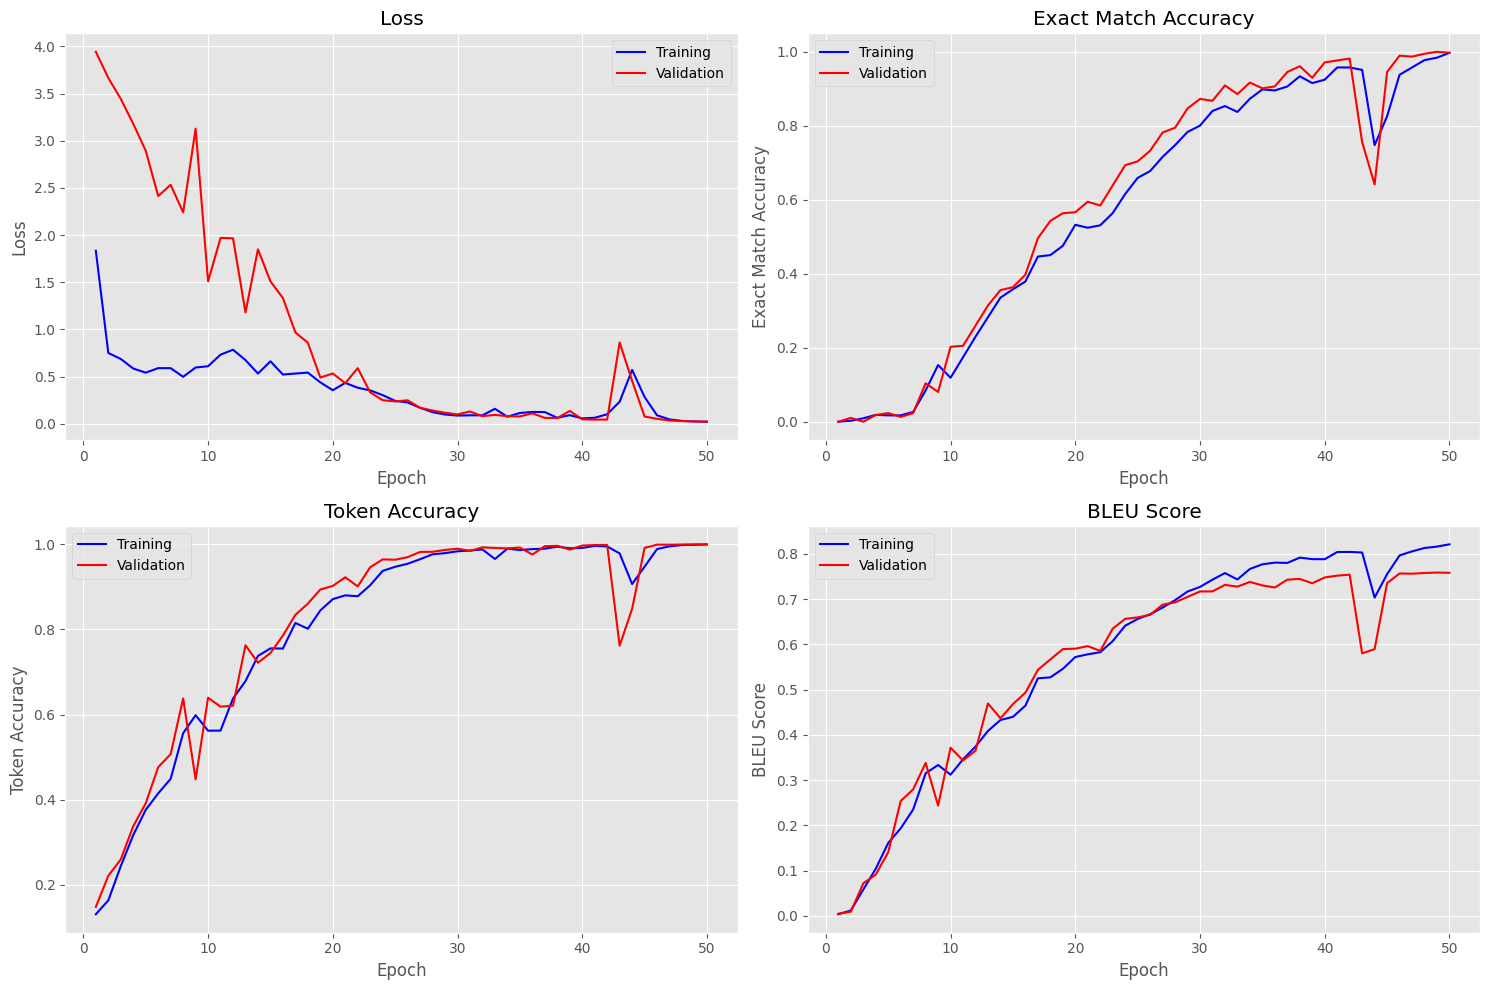

Metrics plots saved to /kaggle/working/metrics_plots


In [73]:
save_dir = "/kaggle/working"
plot_metrics(metrics_history, save_dir)

/tmp/ipykernel_31/18774253.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Predicted LaTeX: e_1^2+e_2^3+e_3^4+e_4^5
True LaTeX: e_1^2 + e_2^3 + e_3^4 + e_4^5


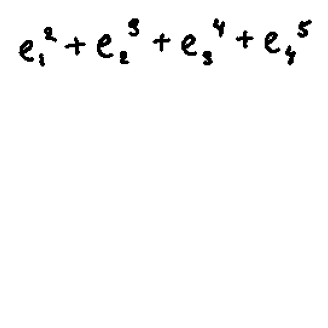

In [79]:
mode = 'predict'  # Options: 'train', 'test', 'predict'
data_root = '/kaggle/input/crohme-data'
checkpoint_path = "checkpoints/best_model.pth"
image_path = "/kaggle/input/crohme-data-basic-final/filtered_basic_arithmetic/test/images/expr_000865.png"
# Prediction mode
if mode == 'predict':
    if not checkpoint_path or not image_path:
        print("Error: Both checkpoint and image paths are required for prediction")
    else:
        # Load model from checkpoint
        model, tokenizer, loaded_config = load_checkpoint(checkpoint_path)
        
        # Update config with loaded config
        for key, value in vars(loaded_config).items():
            setattr(config, key, value)
        filename = os.path.basename(image_path)
        match = re.search(r'expr_(\d+)\.png', filename)
        id = match.group(1)
        image_dir = os.path.dirname(image_path)
        parent_dir = os.path.dirname(image_dir)
        label_path = os.path.join(parent_dir, 'labels', f'expr_{id}.txt')
        f = open(label_path,'r')
        true_latex = f.read()
        
        # Predict on image
        latex = predict_image(model, tokenizer, image_path, config)
        print(f"Predicted LaTeX: {latex}")
        print(f"True LaTeX: {true_latex}")
        
        # Optional: Display the image
        from PIL import Image
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(10, 4))
        plt.imshow(Image.open(image_path).convert('L'), cmap='gray')
        #plt.title(f"Prediction: {latex}")
        plt.axis('off')
        plt.show()